<a href="https://colab.research.google.com/github/Lee-Gunju/Lee-Gunju/blob/master/assignment11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import zipfile
import numpy as np
import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
nltk.download('wordnet')
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
import cupy as cp
from tqdm.auto import tqdm

review_zip = zipfile.ZipFile('movie_review.zip')
review_zip.extractall('') 
review_zip.close()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
review_data = load_files(r"movie_review")
X, y = review_data.data, review_data.target
lamda = 0.5
dictionarys = []

extraction = WordNetLemmatizer()

for sen in range(0, len(X)):
    dictionary = re.sub(r'\W', ' ', str(X[sen]))
    dictionary = re.sub(r'\s+[a-zA-Z]\s+', ' ', dictionary)
    dictionary = re.sub(r'\^[a-zA-Z]\s+', ' ', dictionary) 
    dictionary = re.sub(r'\s+', ' ', dictionary, flags=re.I)
    dictionary = re.sub(r'^b\s+', '', dictionary)
    dictionary = dictionary.lower()
    dictionary = dictionary.split()
    dictionary = [extraction.lemmatize(word) for word in dictionary]
    dictionary = ' '.join(dictionary)
    dictionarys.append(dictionary)

vector = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vector.fit_transform(dictionarys).toarray()

tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
X_train, X_test, y_train, y_test = cp.array(X_train), cp.array(X_test), cp.array(y_train), cp.array(y_test)

In [27]:
class Sequence:
    def __init__(self, layers : list, rate, loss = 'binary'):
        self.Layer = layers
        self.Loss = LossSelector(loss)
        self.Rate = rate

    def predict(self, data):
        h = data
        for l in self.Layer:
            h = l.predict(h)
        return h

    def forward(self, data):
        h = data
        for l in self.Layer:
            h = l.forward(h)
        return h    

    def backpropagate(self, a, label):
        sigma = self.Loss.diff(label, a)
        sum = 0
        for l in reversed(self.Layer):
            sigma, a = l.backward(a, sigma, self.Rate)
            sum += (l.Layer * l.Layer).sum()
        return sum / (2 * a.shape[1]) * lamda

    def train(self, data, label, epoch, *test):
        train_e = []
        train_acc = []
        test_e = []
        test_acc = []
        for i in tqdm(range(epoch)):
            h = self.forward(data)
            if len(test) != 0 : t = self.predict(test[0])
            r = self.backpropagate(h, label)
            train_e.append(self.Loss.calc(label, h) + r)
            train_acc.append(accuracy(h > 0.5, label))
            if len(test) != 0:
                test_e.append(self.Loss.calc(test[1], t) + r)
                test_acc.append(accuracy(t > 0.5, test[1]))

        if len(test) == 0 : return train_e, train_acc
        return train_e, train_acc, test_e, test_acc

class Linear:
    def __init__(self, size, schedule = 'sgd', active = 'sigmoid', bias = False):
        self.size = size
        self.Layer = cp.random.normal(size = (size[0], size[1] + bias), scale = 4*cp.sqrt(2/(size[0] + size[1])))
        self.a = cp.zeros(size[0])
        self.bias = bias
        self.activation = ActivationSelector(active)
        self.scheduler = SchedulerSelector(schedule)

    def forward(self, data):
        self.a = generator(data, self.bias)
        return self.activation.calc(self.Layer@self.a)

    def predict(self, data):
        return self.activation.calc(self.Layer@generator(data, self.bias))

    def backward(self, a, sigma, rate):
        sigma = sigma*self.activation.diff(a)
        dx = sigma@self.a.transpose()/self.a.shape[1] + lamda * self.Layer / a.shape[1]
        t = rate*self.scheduler.grad(dx)
        self.Layer -= t
        return ((self.Layer.transpose()@sigma)[:len(self.a)-self.bias], self.a[:len(self.a)-self.bias])

def accuracy(pred, label):
  return (pred == label).mean()

def generator(data, bias):
  return data if not bias else cp.vstack((data, cp.ones((1, data.shape[1]))))


class Sigmoid:
    def __init__(self):
        pass

    def calc(self, x):
        return cp.reciprocal(1 + np.exp(-x))

    def diff(self, a):
        return a*(1 - a)

class ReLU:
    def __init__(self):
        pass

    def calc(self, x):
        return np.maximum(-0.1*x, x)

    def diff(self, x):
        return (x > 0) - (x <= 0)*0.1

def ActivationSelector(active):
    if active == 'sigmoid': return Sigmoid()
    if active == 'relu': return ReLU()
    print('ActivationSelector : not found %s' % active)

class BinaryLoss:
    def __init__(self):
        pass

    def calc(self, label, pred):
        return -((label*cp.log(pred) + (1 - label)*cp.log(1 - pred)).sum(axis=0)).mean()

    def diff(self, label, pred):
        return -label / pred + (1 - label) / (1 - pred)

def LossSelector(loss):
    if loss == 'binary': return BinaryLoss()
    print('LossSelector : not found %s' % loss)

class SGD():
    def __init__(self):
        pass

    def grad(self, dx):
        return dx

class RMSprop():
    beta = 0.9
    eps = 1e-8
    def __init__(self):
        self.cache = None

    def grad(self, dx):
        self.cache = (dx*dx) if self.cache is None else (RMSprop.beta * self.cache + (1 - RMSprop.beta) * dx*dx)
        return dx/(cp.sqrt(self.cache) + RMSprop.eps)

def SchedulerSelector(schedule):
    if schedule == 'sgd': return SGD()
    if schedule == 'rmsprop': return RMSprop()
    print('SchedulerSelector : not found %s' % schedule)

Model = Sequence([Linear((300, 1500), active = 'sigmoid', bias = True, schedule = 'rmsprop'),
                  Linear((1, 300),   active = 'sigmoid', bias = True, schedule = 'rmsprop')],
                 0.001, 'binary')

train_e, train_acc, test_e, test_acc= Model.train(X_train.T, y_train, 10000, X_test.T, y_test)


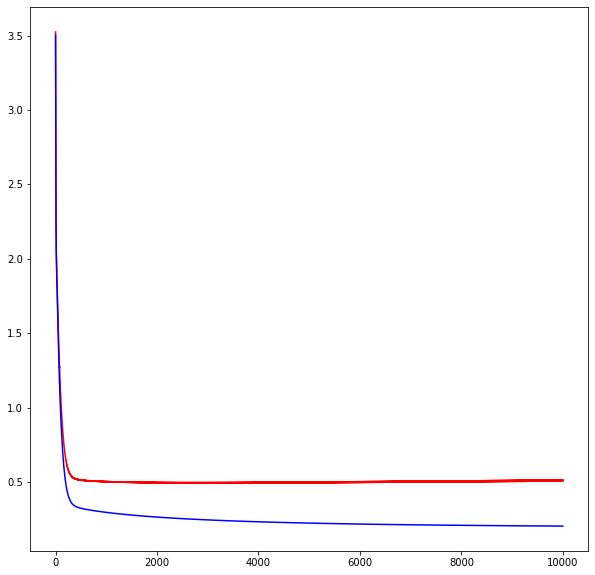

In [28]:
# 1. Plot the loss curve

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(range(0, len(test_e)), test_e, c = 'r')
plt.plot(range(0, len(train_e)), train_e, c = 'b')
plt.show()

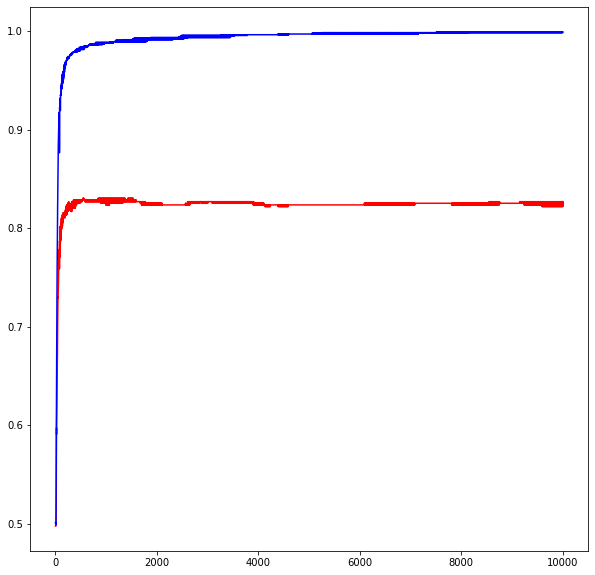

train accuracy : 99.92862241256245 %
test accuracy : 82.6955074875208 %


In [29]:
# 2. Plot the accuracy curve

plt.figure(figsize=(10, 10))
plt.plot(range(0, len(test_acc)), test_acc, c = 'r')
plt.plot(range(0, len(train_acc)), train_acc, c = 'b')
plt.show()


print('train accuracy :', train_acc[-1]*100, '%')
print('test accuracy :', test_acc[-1]*100, '%')

In [32]:
#3. Plot the quantitative results

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

train_h = Model.predict(X_train.T)
print('confusuion matrix')
print(confusion_matrix((train_h > 0.5)[0].tolist(), y_train.tolist()))

print(classification_report(y_train.tolist(), (train_h[0] > 0.5).tolist()))
print('Accuracy: ', accuracy_score(y_train.tolist(), (train_h[0] > 0.5).tolist()) * 100, '%')




confusuion matrix
[[699   2]
 [  0 700]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       699
           1       1.00      1.00      1.00       702

    accuracy                           1.00      1401
   macro avg       1.00      1.00      1.00      1401
weighted avg       1.00      1.00      1.00      1401

Accuracy:  99.85724482512491 %


In [33]:
# 4. Testing accuracy [30pt]

test_h = Model.predict(X_test.T)
print('Confusion Matrix')
print(confusion_matrix((train_h > 0.5)[0].tolist(), y_train.tolist()))

print(classification_report(y_test.tolist(), (test_h[0] > 0.5).tolist()))
print('Accuracy: ', accuracy_score(y_test.tolist(), (test_h[0] > 0.5).tolist()) * 100, '%')


Confusion Matrix
[[699   2]
 [  0 700]]
              precision    recall  f1-score   support

           0       0.82      0.83      0.82       302
           1       0.82      0.82      0.82       299

    accuracy                           0.82       601
   macro avg       0.82      0.82      0.82       601
weighted avg       0.82      0.82      0.82       601

Accuracy:  82.19633943427621 %
